In [1]:
import os
import math
import warnings
import numpy as np
import astropy.stats as st
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import collections as col
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [2]:
sns.set_style('white')
plt.rc("axes.spines", top=False, right=False)
plt.rcParams['figure.figsize'] = (8, 5)

In [3]:
fields = np.load('./data/processed/MODIS_night_data.npz')['fields']
fields = fields.reshape([fields.shape[0], -1])
metadata = np.load('./data/processed/MODIS_night_data.npz', allow_pickle=True)['metadata']
mask = ~np.isnan(fields)
fields[~mask] = 0

In [4]:
m = int(0.1 * fields.shape[0])
idx = shuffle(np.arange(fields.shape[0]))
train_idx = idx[m:]
valid_idx = idx[:m]
train_fields = fields[train_idx]
valid_fields = fields[valid_idx]
train_mask = mask[train_idx]
valid_mask = mask[valid_idx]

In [5]:
train_fields.shape, valid_fields.shape, train_mask.shape, valid_mask.shape

((1024, 9216), (113, 9216), (1024, 9216), (113, 9216))

In [6]:
scaler = StandardScaler()
train_fields = scaler.fit_transform(train_fields)
valid_fields = scaler.transform(valid_fields)

In [7]:
n_comp = [1, 4, 16, 64, 256, 512, 1024]

In [9]:
evs, mses = [], []
for nc in tqdm(n_comp):
    pca = PCA(nc)
    pca.fit(train_fields)
    ev = sum(pca.explained_variance_ratio_)
    evs.append(ev)
    x = scaler.inverse_transform(valid_fields)
    rx = scaler.inverse_transform(pca.inverse_transform(pca.transform(valid_fields)))
    mse = np.square((x - rx) * valid_mask).sum() / valid_mask.sum()
    mses.append(mse)

100%|██████████| 7/7 [00:23<00:00,  3.29s/it]


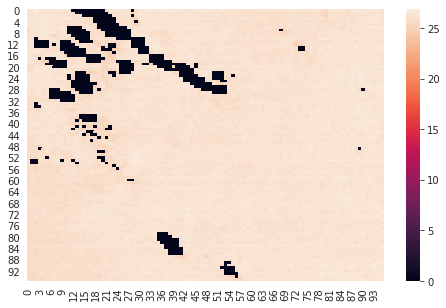

In [14]:
idx = np.random.choice(x.shape[0])
sns.heatmap(x[idx].reshape([96, 96]))

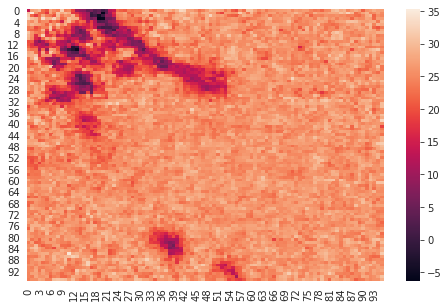

In [15]:
sns.heatmap(rx[idx].reshape([96, 96]))

Text(0, 0.5, 'Total Explained Variance')

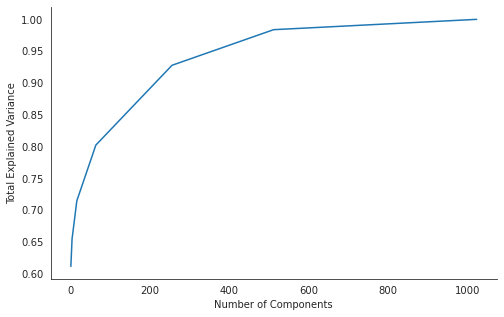

In [10]:
plt.plot(n_comp, evs)
plt.xlabel('Number of Components')
plt.ylabel('Total Explained Variance')

Text(0, 0.5, 'Mean Squared Error')

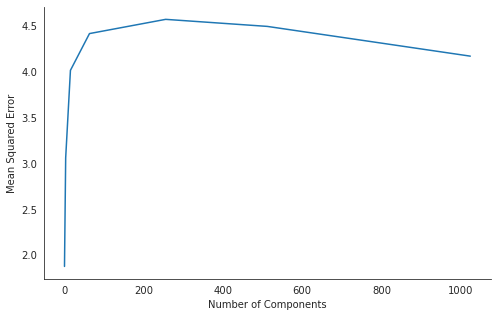

In [11]:
plt.plot(n_comp, mses)
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error')

In [11]:
evs

[0.6158448457717896,
 0.6585544152185321,
 0.7182159447111189,
 0.8048402949934825,
 0.9279662336339243,
 0.9836926850257441,
 0.999999905443449]

In [12]:
mses

[20.464012, 16.946302, 13.3873825, 10.3380575, 7.758791, 6.329376, 4.8080173]

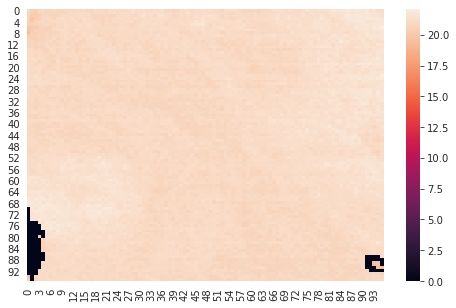

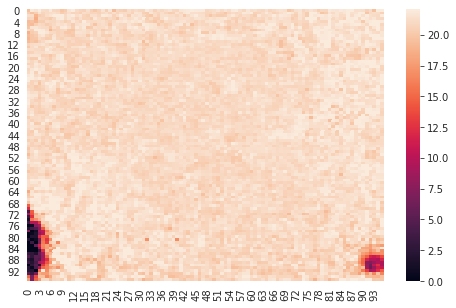

In [30]:
rand_idx = np.random.choice(valid_fields.shape[0])
x = valid_fields[rand_idx:rand_idx+1]
rx = pca.inverse_transform(pca.transform(x))
x, rx = scaler.inverse_transform(x), scaler.inverse_transform(rx)
x, rx = x.reshape([96, 96]), rx.reshape([96, 96])
vmin, vmax = x[x != 0].min(), x[x != 0].max()
sns.heatmap(x, vmin=vmin, vmax=vmax)
plt.show()
sns.heatmap(rx, vmin=vmin, vmax=vmax)
plt.show()